該 import 的東西都差不多 import 完了，所以可以直接複製這個檔案作為開頭 section，直接開始後面的分析。

In [1]:
# import required packages, though not all of them are actually used
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.mlab as mlab
import matplotlib.dates as mpl_dates
%matplotlib inline

import mplfinance as mpf 
from mplfinance.original_flavor import candlestick_ohlc
# set fig size; bigger DPI results in bigger fig
plt.rcParams["figure.dpi"] = 100

import seaborn as sns
import pandas as pd
import numpy as np
import sympy as sp
import math
import scipy.stats as stats
from scipy.stats import norm
from scipy.optimize import curve_fit
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
from statsmodels.stats.stattools import durbin_watson as sdw
import statsmodels.stats.libqsturng
import plotly.express as px
from datetime import datetime

import stemgraphic as stem

# from ete3 import Tree, faces, AttrFace, TreeStyle, TextFace

# from mgt2001 import *

import mgt2001
from mgt2001.hyp.ind import two_population, two_population_proportion
import mgt2001.hyp.anova as anova
import mgt2001.hyp.chi2 as chi2
import mgt2001.hyp.non as non

import random
import itertools
import math

plt.style.use('ggplot') # refined style

mgt2001.__version__ # show version of mgt2001

'0.4.1.4'

## Data Processing

In [2]:
movie_df = pd.read_excel('../data/sorted_all_movie.xlsx', engine='openpyxl', index_col=0)
covid_date = datetime(2020, 3, 1)
movie_df['has_collection'] = movie_df['belongs_to_collection'].isna().replace({True: 0, False: 1})
movie_df['pre_covid'] = (movie_df['release_date'] < covid_date).replace({True: 1, False: 0})
movie_df['post_covid'] = (movie_df['release_date'] >= covid_date).replace({True: 1, False: 0})
movie_df['release_year'] = movie_df['release_date'].apply(lambda x: x.year)
movie_df['release_month'] = movie_df['release_date'].apply(lambda x: x.month)

display(movie_df.head())
display(movie_df.tail())

,id,title,budget,genres,original_language,production_companies,release_date,TW_release_date,revenue,runtime,...,rating,rotten_aud_score,zh_title,belongs_to_collection,has_homepage,has_collection,pre_covid,post_covid,release_year,release_month
0,4234,Scream 3,40000000,"['Horror', 'Mystery']",en,"['Craven-Maddalena Films', 'Dimension Films', ...",2000-02-03,NaN,161834276,116,...,R,37.0,驚聲尖叫3：終結篇,Scream Collection,0,1,1,0,2000,2
1,1907,The Beach,40000000,"['Drama', 'Adventure', 'Romance', 'Thriller']",en,['Figment Films'],2000-02-03,NaN,144056873,119,...,R,57.0,海灘,NaN,0,0,1,0,2000,2
2,15655,The Tigger Movie,30000000,"['Family', 'Animation', 'Comedy']",en,"['Disney Television Animation', 'DisneyToon St...",2000-02-11,NaN,45554533,77,...,G,62.0,跳跳虎歷險記,NaN,1,0,1,0,2000,2
3,14181,Boiler Room,7000000,"['Crime', 'Drama', 'Thriller']",en,['New Line Cinema'],2000-02-18,NaN,28780255,118,...,R,78.0,搶錢大作戰,NaN,0,0,1,0,2000,2
4,2069,The Whole Nine Yards,41300000,"['Comedy', 'Crime']",en,"['Franchise Pictures', 'Morgan Creek Productio...",2000-02-18,NaN,106371651,98,...,R,64.0,殺手不眨眼,The Whole Nine/Ten Yards Collection,0,1,1,0,2000,2


,id,title,budget,genres,original_language,production_companies,release_date,TW_release_date,revenue,runtime,...,rating,rotten_aud_score,zh_title,belongs_to_collection,has_homepage,has_collection,pre_covid,post_covid,release_year,release_month
3167,460465,Mortal Kombat,20000000,"['Action', 'Fantasy', 'Adventure']",en,"['Atomic Monster', 'Broken Road Productions', ...",2021-04-07,NaN,76706000,110,...,R,86.0,真人快打,NaN,1,0,0,1,2021,4
3168,637649,Wrath of Man,40000000,"['Action', 'Crime']",en,"['Miramax', 'Metro-Goldwyn-Mayer', 'Toff Guy F...",2021-04-22,2021-04-29T00:00:00.000Z,80648577,119,...,R,91.0,玩命鈔劫,NaN,1,0,0,1,2021,4
3169,520663,The Woman in the Window,4000000,"['Crime', 'Mystery', 'Thriller']",en,"['Fox 2000 Pictures', 'Scott Rudin Productions...",2021-05-14,NaN,0,102,...,R,36.0,窺探,NaN,1,0,0,1,2021,5
3170,503736,Army of the Dead,90000000,"['Action', 'Horror', 'Thriller']",en,['The Stone Quarry'],2021-05-14,NaN,780000,148,...,NaN,NaN,活屍大軍,Army of the Dead Collection,1,1,0,1,2021,5
3171,337404,Cruella,200000000,"['Comedy', 'Crime']",en,['Walt Disney Pictures'],2021-05-26,NaN,46586903,134,...,PG-13,97.0,時尚惡女：庫伊拉,Cruella Collection,1,1,0,1,2021,5


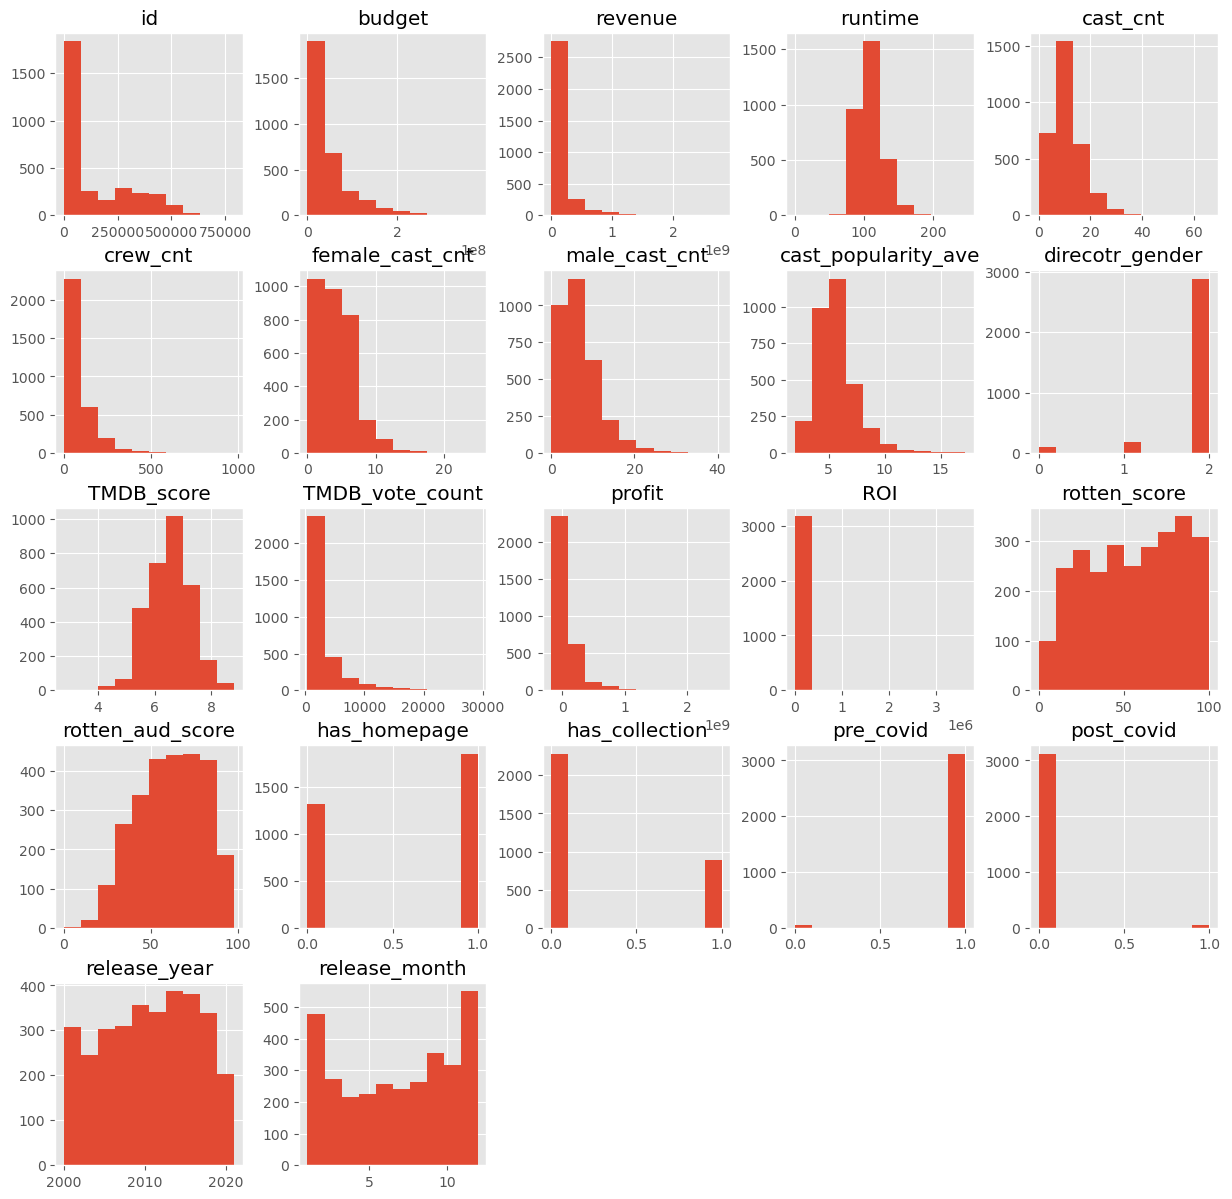

In [3]:
movie_df.hist(figsize=(15, 15))
plt.show()

可以看出裡面有需多 outliers，這些 data points 很可能影響到整體結果，所以我們將不考慮這些電影的計算。

在這邊，我們也可以看到 "revenue"、"budget"、"ROI" 這三個重點項目都不是常態分佈，要做分析的話會有點困難。這時候，我們可以採用 `np.log1p()` 來做 data transformation。如要要做預測的話，則是用 `np.exp1p()` 來還原。這部分，會在去除玩異質之後統一處理。

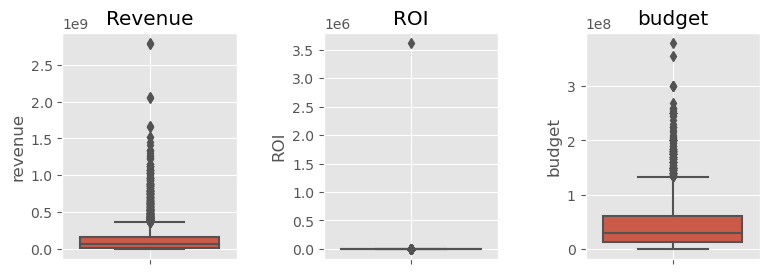

In [4]:
# Plot
fig = plt.figure(figsize=(9, 3))
row, col = 1, 3
fig.subplots_adjust(hspace=0.2, wspace=.5)
ax = fig.add_subplot(row, col, 1)
ax = sns.boxplot(y=movie_df['revenue']) # orient='h' results in horizontal boxplot
plt.title('Revenue')
ax.grid(True)
ax = fig.add_subplot(row, col, 2)
ax = sns.boxplot(y=movie_df['ROI']) # orient='h' results in horizontal boxplot
plt.title('ROI')
ax.grid(True)

ax = fig.add_subplot(row, col, 3)
ax = sns.boxplot(y=movie_df['budget']) # orient='h' results in horizontal boxplot
plt.title('budget')
ax.grid(True)


plt.show()

<div class="alert alert-block alert-info">
<b>你知道嗎？</b> 票房最高的電影是 2019 年上映的復仇者聯盟：終局之戰。</div>

In [5]:
movie_df[movie_df['revenue'] == movie_df['revenue'].max()]

,id,title,budget,genres,original_language,production_companies,release_date,TW_release_date,revenue,runtime,...,rating,rotten_aud_score,zh_title,belongs_to_collection,has_homepage,has_collection,pre_covid,post_covid,release_year,release_month
3005,299534,Avengers: Endgame,356000000,"['Adventure', 'Science Fiction', 'Action']",en,['Marvel Studios'],2019-04-24,2019-04-24T00:00:00.000Z,2797800564,181,...,PG-13,90.0,復仇者聯盟：終局之戰,The Avengers Collection,1,1,1,0,2019,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2248 entries, 0 to 2247
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     2248 non-null   int64         
 1   title                  2248 non-null   object        
 2   budget                 2248 non-null   int64         
 3   genres                 2248 non-null   object        
 4   original_language      2248 non-null   object        
 5   production_companies   2248 non-null   object        
 6   release_date           2248 non-null   datetime64[ns]
 7   TW_release_date        500 non-null    object        
 8   revenue                2248 non-null   int64         
 9   runtime                2248 non-null   int64         
 10  cast                   2248 non-null   object        
 11  cast_cnt               2248 non-null   int64         
 12  crew_cnt               2248 non-null   int64         
 13  fem

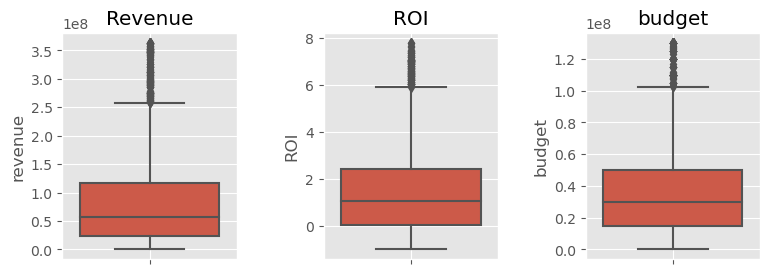

In [6]:
rev_outlier = mgt2001.des.outlier(movie_df['revenue'].dropna(), show=False)[0]
roi_outlier = mgt2001.des.outlier(movie_df['ROI'].dropna(), show=False)[0]
budget_outlier = mgt2001.des.outlier(movie_df['budget'].dropna(), show=False)[0]

def filter_rows_by_values(df, col, values):
    return df[df[col].isin(values) == False]

rev_df = movie_df[movie_df['revenue'] >= 1e5 * 9] # 排除 90 萬以下票房的資料點（這些點沒有被移除）
rev_df = filter_rows_by_values(rev_df, 'revenue', rev_outlier).reset_index(drop=True)
roi_df = filter_rows_by_values(movie_df, 'ROI', roi_outlier).reset_index(drop=True)
budget_df = filter_rows_by_values(movie_df, 'budget', budget_outlier).reset_index(drop=True)

u_movie_df = movie_df[movie_df['revenue'] >= 1e5 * 9] # 排除 90 萬以下票房的資料點（這些點沒有被移除）
u_movie_df = filter_rows_by_values(u_movie_df, 'revenue', rev_outlier).reset_index(drop=True)
u_movie_df = filter_rows_by_values(u_movie_df, 'ROI', roi_outlier).reset_index(drop=True)
u_movie_df = filter_rows_by_values(u_movie_df, 'budget', budget_outlier).reset_index(drop=True)

print(u_movie_df.info()) 

# Plot
fig = plt.figure(figsize=(9, 3))
row, col = 1, 3
fig.subplots_adjust(hspace=0.2, wspace=.5)
ax = fig.add_subplot(row, col, 1)
ax = sns.boxplot(y=u_movie_df['revenue']) # orient='h' results in horizontal boxplot
plt.title('Revenue')
ax.grid(True)
ax = fig.add_subplot(row, col, 2)
ax = sns.boxplot(y=u_movie_df['ROI']) # orient='h' results in horizontal boxplot
plt.title('ROI')
ax.grid(True)

ax = fig.add_subplot(row, col, 3)
ax = sns.boxplot(y=u_movie_df['budget']) # orient='h' results in horizontal boxplot
plt.title('budget')
ax.grid(True)


plt.show()

這明顯已經較上面所看到的 box plots 好上許多。因此我們便用剩下的 2248 筆資料進行更近一步的分析。另外，在這邊也要注意到，不是所有的 column 都是 2248 筆資料，有些 data 是有少的。所以在做分析時要格外小心。

In [7]:
u_movie_df['log_revenue'] = np.log1p(u_movie_df['revenue'])
u_movie_df['log_budget'] = np.log1p(u_movie_df['budget'])
u_movie_df['log_ROI'] = np.log1p(u_movie_df['ROI'])

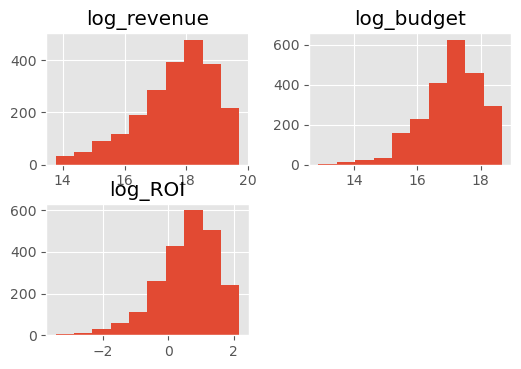

In [8]:
u_movie_df[['log_revenue', 'log_budget', 'log_ROI']].hist()
plt.show()

我們對revenue、budget、ROI三項變數取對數，使這三項變數趨於常態分佈，以利於後續模型的建立。

## Data Analysis

## 一、疫情前後的票房差異

2019年底，全球疫情爆發，隨著八大場所的關閉，電影院的生意也因此大受打擊。時至今日，疫苗逐漸普及，疫情稍為緩和，我們想要知道「電影營收是否依舊受到影響」。我們假設2020/10/01（第四季）後的電影依舊受到疫情影響，以此假設分析：「2019/10/01 - 2019/12/31」與「2020/10/01 - 2020/12/31」的電影票房是否有差異。

In [9]:
covid_df = u_movie_df[((u_movie_df.release_date >= '2019-01-01'))]
covid_df_t1 = covid_df[((covid_df.release_date >= '2019-10-01') & (covid_df.release_date <= '2019-12-31'))]
covid_df_t2 = covid_df[((covid_df.release_date >= '2020-10-01'))]
covid_revenue = {'before_covid': covid_df_t1.revenue.dropna().reset_index().revenue,
                 'after_covid' : covid_df_t2.revenue.dropna().reset_index().revenue}
covid_df_revenue = pd.DataFrame(covid_revenue)
display(covid_df_revenue.head())
display(covid_df_revenue.tail())

,before_covid,after_covid
0,122801777,1070714.0
1,203044905,15104310.0
2,82468705,168285000.0
3,18123239,25814306.0
4,48021766,12886100.0


,before_covid,after_covid
22,61404394,NaN
23,17133446,NaN
24,73515024,NaN
25,191540586,NaN
26,50401502,NaN


In [10]:
before = covid_df_revenue['before_covid'].dropna().values
after = covid_df_revenue['after_covid'].dropna().values

**檢查資料是否為常態分佈**

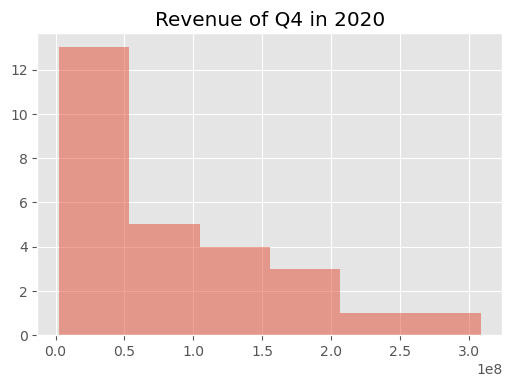

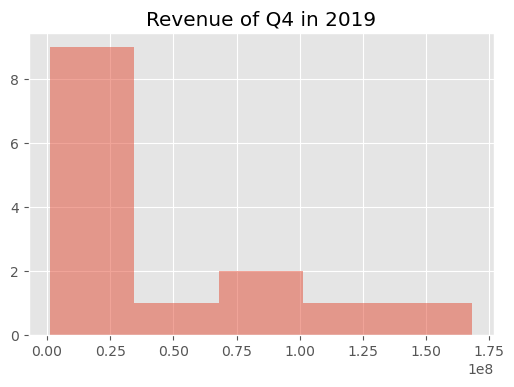

In [11]:
_ = plt.hist(before, bins = 'auto', alpha=0.5)
plt.title('Revenue of Q4 in 2020')
plt.show()

_ = plt.hist(after, bins = 'auto', alpha=0.5)
plt.title('Revenue of Q4 in 2019')
plt.show()

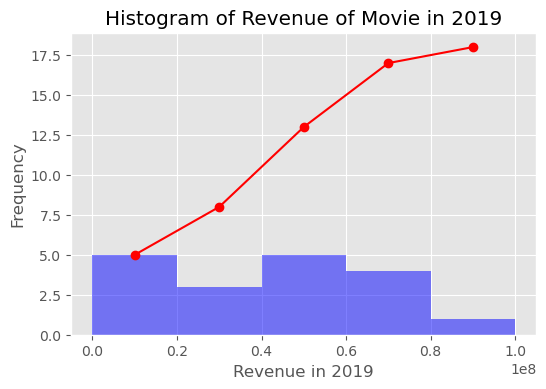

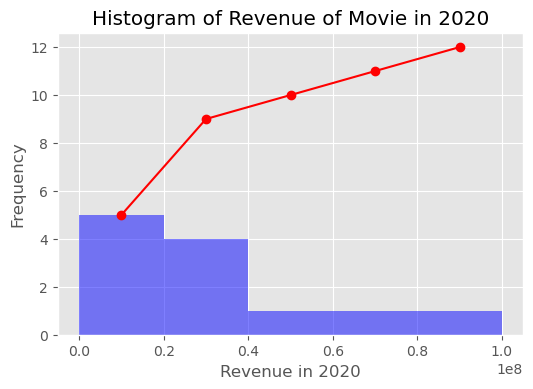

In [12]:
# the histogram of the data
bins_list = [0, 0.2e8, 0.4e8, 0.6e8, 0.8e8, 1e8]
fig, ax = plt.subplots()
counts, bins, patches = plt.hist(before, bins=bins_list, density=False, facecolor='b', alpha=0.5)
plt.xlabel('Revenue in 2019')
plt.ylabel('Frequency')
plt.title('Histogram of Revenue of Movie in 2019')
plt.grid(True)
plt.xticks(bins_list)
bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
ax.plot(bin_centers, counts.cumsum(), 'ro-')
plt.show()

# the histogram of the data
bins_list = [0, 0.2e8, 0.4e8, 0.6e8, 0.8e8, 1e8]
fig, ax = plt.subplots()
counts, bins, patches = plt.hist(after, bins=bins_list, density=False, facecolor='b', alpha=0.5)
plt.xlabel('Revenue in 2020')
plt.ylabel('Frequency')
plt.title('Histogram of Revenue of Movie in 2020')
plt.grid(True)
plt.xticks(bins_list)
bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
ax.plot(bin_centers, counts.cumsum(), 'ro-')
plt.show()

由以上的長條圖，我們可以認定兩資料非常態分佈，因此使用 Wilcoxon Rank Sum Test。

+ $H_0:$ The locations of the two populations are the same. <br>
+ $H_1:$ The locations of before_covid(2019/10 - 2019/12) is greater than after_covid(2020/10 - 2020/12).

In [13]:
stats.mannwhitneyu(before , after , alternative = 'greater')

MannwhitneyuResult(statistic=266.0, pvalue=0.017723946276230383)

由檢定結果發現 p-value < 0.05，因此我們可以拒絕虛無假設，推論一直到2020/10第四季後的電影票房依然受到影響。若將信心水準調整至0.01，則會顯示沒有差異，因此我們認為電影票房一直到2020年底之後，就有回穩的趨勢。

我們接著拿 2020/07 - 2020/09 的資料與 2020/10 - 2020/12 比較，確認是否有回穩的趨勢。

In [14]:
covid_df_t1 =  covid_df[((covid_df.release_date >= '2020-07-01') & (covid_df.release_date <= '2020-09-30'))]
covid_df_t2 =  covid_df[((covid_df.release_date >= '2020-10-01'))]
covid_revenue = {'phase1': covid_df_t1.revenue.dropna().reset_index().revenue,
                 'phase2' : covid_df_t2.revenue.dropna().reset_index().revenue}
covid_df_revenue = pd.DataFrame(covid_revenue)
display(covid_df_revenue.head())
display(covid_df_revenue.tail())

phase1 = covid_df_revenue['phase1'].dropna().values
phase2 = covid_df_revenue['phase2'].dropna().values

,phase1,phase2
0,39657073.0,1070714
1,39238300.0,15104310
2,47800000.0,168285000
3,4700000.0,25814306
4,45534613.0,12886100


,phase1,phase2
9,NaN,6416063
10,NaN,47019435
11,NaN,30763855
12,NaN,76706000
13,NaN,80648577


+ $H_0:$ The locations of the two populations are the same. <br>
+ $H_1:$ The locations of phase1(2020/7 - 2020/9) is less than phase2(2020/10 - 2020/12).

In [15]:
stats.mannwhitneyu(phase1 , phase2 , alternative = 'less')

MannwhitneyuResult(statistic=45.0, pvalue=0.397001340096381)

由檢定結果發現 p-value > 0.05，因此我們不可以拒絕虛無假設，推論一直到2020/10第四季後的電影票房相較於第三季已有好轉，不過因為疫情後之票房依然受到影響，因此接下來的分析，我們將去除疫情後的資料。

## 二、票房與投入成本的關係

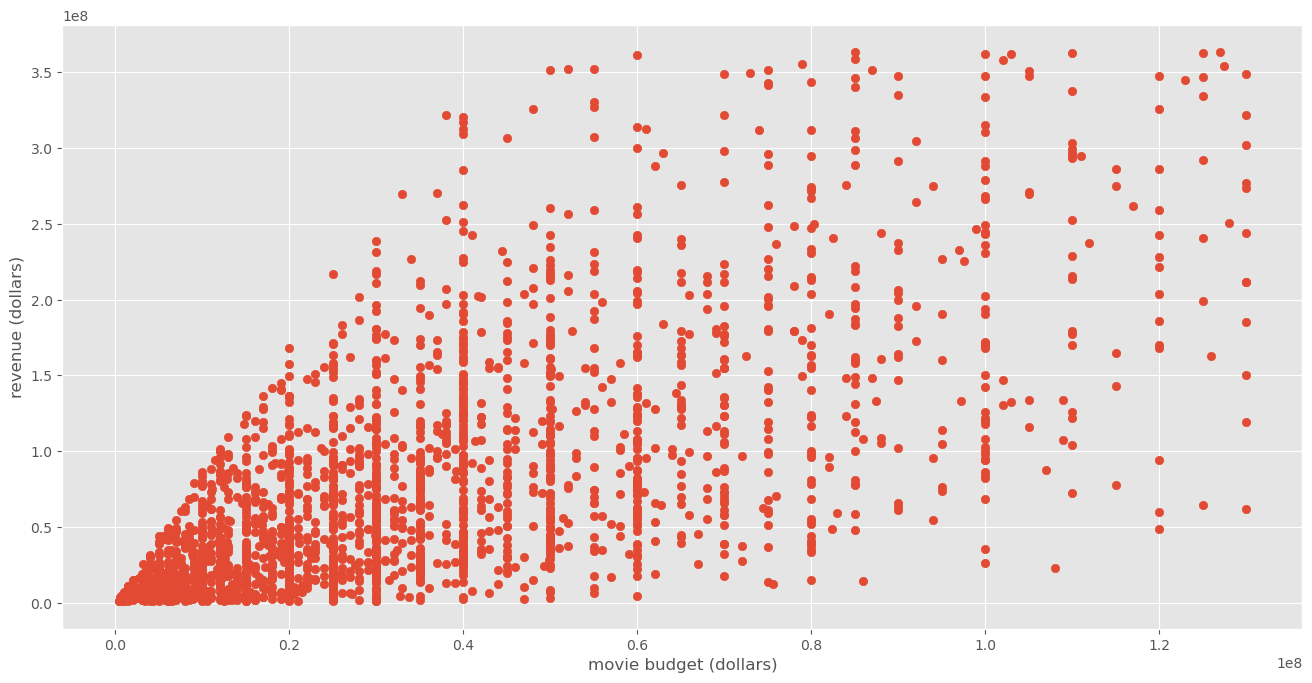

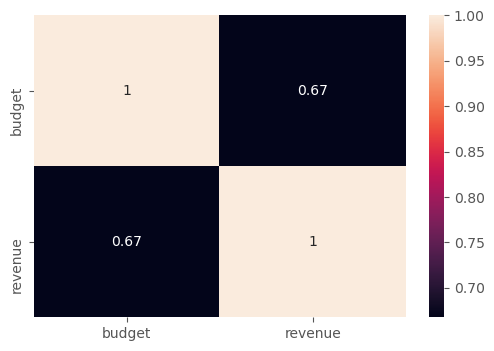

In [16]:
data_b_r = u_movie_df[['budget', 'revenue']]

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data_b_r['budget'], data_b_r['revenue'])
ax.set_xlabel('movie budget (dollars)')
ax.set_ylabel('revenue (dollars)')
plt.show()

corr = data_b_r.corr()
_ = sns.heatmap(corr, annot=True)

從以上的散布圖我們可以看見具備一定程度的線性關係，我們使用 Pearson Correlation of Coefficient test 來驗證。

兩變數 budget, revenue 之間的關係為 $\rho$，當 $\rho = 0$ 時，代表選定的兩變數無關。

+ $H_0$: $\rho = 0$<br>
+ $H_1$: $\rho \neq  0$

In [17]:
stats.spearmanr(data_b_r['budget'], data_b_r['revenue'])

SpearmanrResult(correlation=0.6924938298350513, pvalue=7.61e-321)

由檢定結果發現 p-value > 0.05，因此我們可以拒絕虛無假設，推測投入成本與票房相關。

## 三、票房與參演者的關係：男女演員的多寡會不會影響票房

隨著性別平權議題、女權意識抬頭，越來越多人對於這樣的思潮越來越關注。2017年的#metoo運動，更是揭露了美國影視產業對於女性的種種不平等。以此為發想，我們希望可以探究：觀眾喜好是否有受到自19世紀後期開始的女權思潮影響。

<div class="alert alert-block alert-info">
<b>🍿 你知道嗎？</b><br>
    
在2007年到2012年間，有台詞的女性角色比例僅佔30.8%</div>

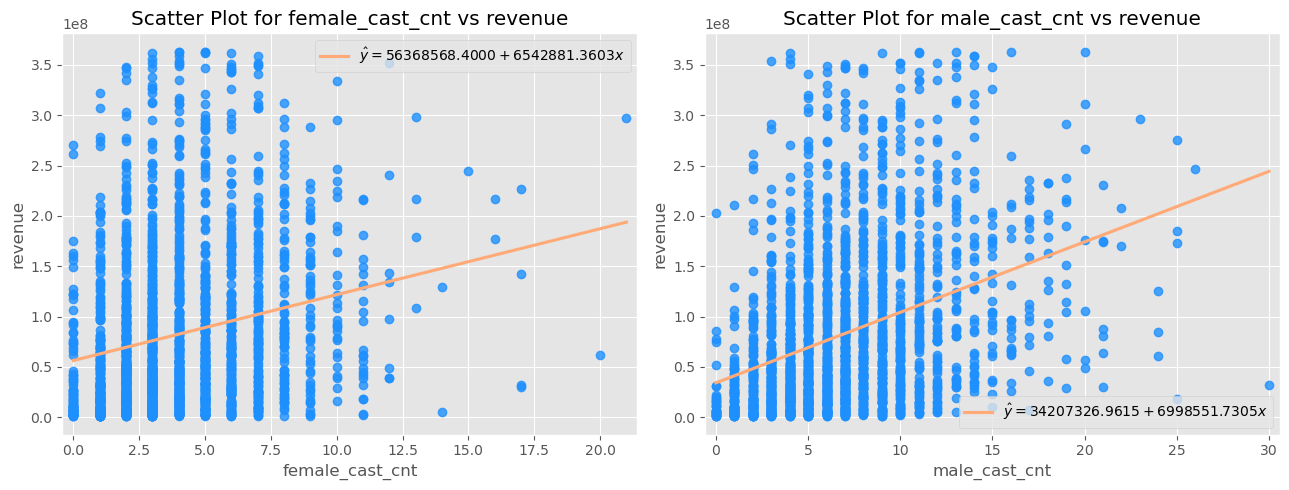

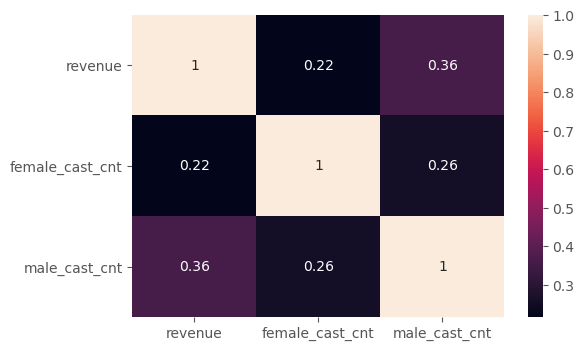

In [18]:
cast_gender = u_movie_df[['revenue', 'female_cast_cnt', 'male_cast_cnt']].copy()
cast_col = ['female_cast_cnt', 'male_cast_cnt']
mgt2001.model.multi_scatter_plot(1, 2, cast_gender, cast_col, 'revenue', figsize=(13, 5))

可以自散佈圖x軸線發現，男性演員數量明顯大於女性演員數量。然而這樣依然無法看出女性演員對於電影票房的影響力（演員數量多，投入成本相對較高，根據上一個檢定，票房也相對較高），因此我們決定探究：女性演員不少於男性演員的電影，票房是否較高。

In [19]:
cast_gender["diff"] = cast_gender["female_cast_cnt"] - cast_gender["male_cast_cnt"]
print(cast_gender)   

m = cast_gender['diff'] > 0
positive, negative = cast_gender[m], cast_gender[~m]

        revenue  female_cast_cnt  male_cast_cnt  diff
0     161834276                8             12    -4
1     144056873                4              3     1
2      45554533                1              5    -4
3      28780255                2             12   -10
4     106371651                5              5     0
...         ...              ...            ...   ...
2243    6416063                1              8    -7
2244   47019435                2             10    -8
2245   30763855                3              4    -1
2246   76706000                1             12   -11
2247   80648577                3             13   -10

[2248 rows x 4 columns]


$t$-test:

+ $H_0$: $\mu_1 - \mu_2 = 0$
+ $H_1$: $\mu_1 - \mu_2 < 0$.

其中，
+ $\mu_1$: average revenue that female cast count is greater than male cast count
+ $\mu_2$: average revenue that female cast count is smaller than male cast count

Check normality first:

1. 直方圖
2. Shapiro檢定<br>

+ $H_0$: The population is normally distributed
+ $H_1$: The population is not normally distributed

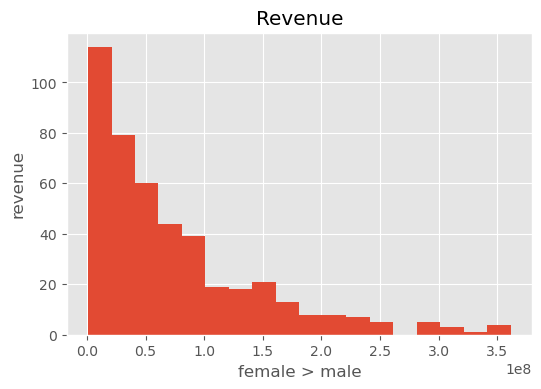

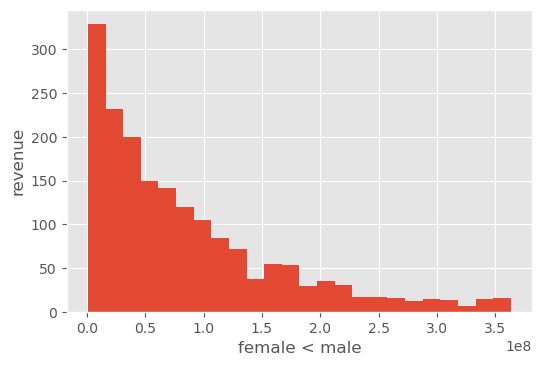

Sample 1:
ShapiroResult(statistic=0.8351048231124878, pvalue=3.655018705600595e-21)
Sample 2:
ShapiroResult(statistic=0.8552992343902588, pvalue=8.793742014187101e-38)


In [20]:
# 轉換成numpy array
sample1 = positive['revenue'].values
sample2 = negative['revenue'].values

# 移除nan
sample1 = sample1[~np.isnan(sample1)]
sample2 = sample2[~np.isnan(sample2)]

#自由度計算
v1 = sample1.shape[0] - 1
v2 = sample2.shape[0] - 1

#畫histogram確認是否常態分佈
fig = plt.hist(sample1, bins = 'auto')
plt.title('Revenue')
plt.ylabel('revenue')
plt.xlabel("female > male")
plt.show()

fig = plt.hist(sample2, bins = 'auto')
plt.title('')
plt.ylabel('revenue')
plt.xlabel("female < male")
plt.show()

#Shapiro Test
print("Sample 1:")
print(stats.shapiro(sample1))
print("Sample 2:")
print(stats.shapiro(sample2))

根據上方的直方圖和Shapiro檢定結果(p-value < 0.05，拒絕虛無假設），我們可以推測資料不是常態分佈。

因此，我們改使用Wilcoxon Rank Sum test.

$H_0$: The two population locations are the same <br>
$H_1$: The location of the population 1 is to the right of the location of population 2.

population 1: average revenue that female cast count is greater than male cast count<br>
population 2: average revenue that female cast count is smaller than male cast count

In [21]:
stats.ranksums(positive['revenue'], negative['revenue'])

RanksumsResult(statistic=-2.64763605182215, pvalue=0.008105673661706355)

由上述檢定結果（p-vlaue < 0.05)，我們可以拒絕虛無假設，可以推論當女性演員數量大於男性演員數量時，票房較高。

## 四、評分網站的差異：

#### 1. 影評人與大眾評分差異比較：

電影評分網站Rotten Tomato有許多評分機制，其中最受到矚目的兩個分別是「影評人的評分」與「大眾的評分」。以此為發想，我們比較Rotten Tomato上影評人與大眾的評分是否存在差異。 

In [22]:
df_compare_rating_1 = u_movie_df[['rotten_score', 'rotten_aud_score']].copy()
df_compare_rating_1 = df_compare_rating_1.dropna().reset_index()
print('Head of dataset:')
display(df_compare_rating_1.head())
print("Tail of dataset:")
display(df_compare_rating_1.tail())

Head of dataset:


,index,rotten_score,rotten_aud_score
0,0,40.0,37.0
1,1,20.0,57.0
2,2,62.0,62.0
3,3,66.0,78.0
4,4,44.0,64.0


Tail of dataset:


,index,rotten_score,rotten_aud_score
1916,2243,96.0,95.0
1917,2244,83.0,94.0
1918,2245,29.0,57.0
1919,2246,55.0,86.0
1920,2247,66.0,91.0


**檢查資料是否為常態分佈**

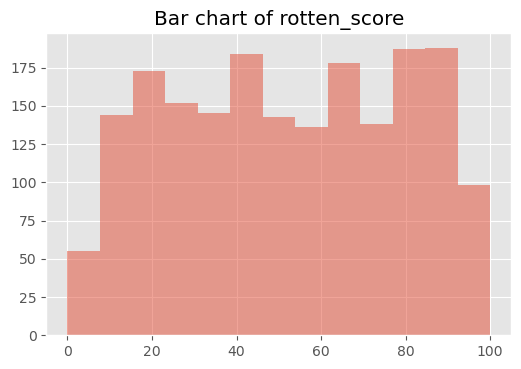

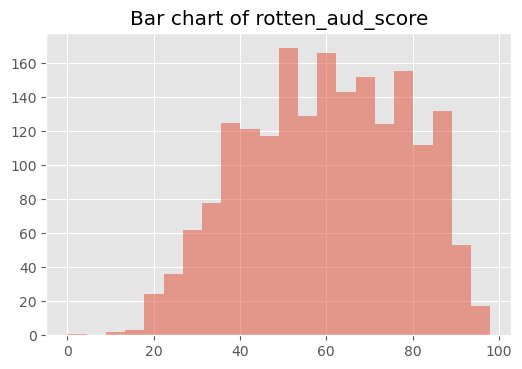

In [23]:
_ = plt.hist(df_compare_rating_1['rotten_score'], bins = 'auto', alpha=0.5)
plt.title('Bar chart of rotten_score')
plt.show()

_ = plt.hist(df_compare_rating_1['rotten_aud_score'], bins = 'auto', alpha=0.5)
plt.title('Bar chart of rotten_aud_score')
plt.show()

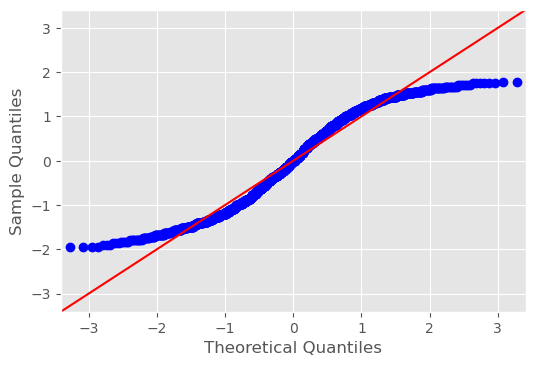

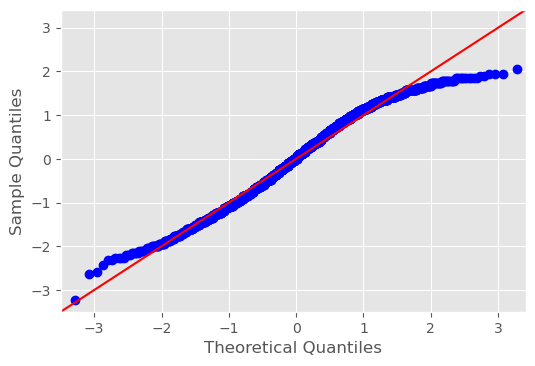

In [24]:
fig = sm.qqplot(df_compare_rating_1['rotten_score'], stats.norm, fit=True, line='45')
fig = sm.qqplot(df_compare_rating_1['rotten_aud_score'], stats.norm, fit=True, line='45')

從直方圖和 Shapiro test 之後，我們認定 rotten_score 為非常態分佈，rotten_aud_score 為常態分佈，因此採用 Wilcoxon Signed Rank Sum Test.

+ $H_0:$ The two population locations are the same
+ $H_1:$ The two population locations are NOT the same

In [25]:
stats.wilcoxon(df_compare_rating_1['rotten_score'], df_compare_rating_1['rotten_aud_score'], alternative='two-sided')

WilcoxonResult(statistic=523566.5, pvalue=1.952750775214582e-54)

由檢定結果發現 p-value < 0.05，因此我們可以拒絕虛無假設，推論專業影評人與觀眾評分不盡相同。

#### 2.不同平台間觀眾評分比較: TMDB vs Rotten Tomato

我們好奇針對同一部電影在不同平台上的觀眾評分是否有差異，因此比較爛番茄觀眾評分及TMDb上的觀眾評分結果是否相同。

In [26]:
df_compare_rating_2 = u_movie_df[['TMDB_score','rotten_aud_score']].copy()
df_compare_rating_2 = df_compare_rating_2.dropna().reset_index()
df_compare_rating_2['TMDB_score'] = df_compare_rating_2['TMDB_score']*10 
print('Head of dataset:')
display(df_compare_rating_2.head())
print("Tail of dataset:")
display(df_compare_rating_2.tail())

Head of dataset:


,index,TMDB_score,rotten_aud_score
0,0,59.0,37.0
1,1,64.0,57.0
2,2,65.0,62.0
3,3,67.0,78.0
4,4,64.0,64.0


Tail of dataset:


,index,TMDB_score,rotten_aud_score
1916,2243,75.0,95.0
1917,2244,85.0,94.0
1918,2245,71.0,57.0
1919,2246,76.0,86.0
1920,2247,79.0,91.0


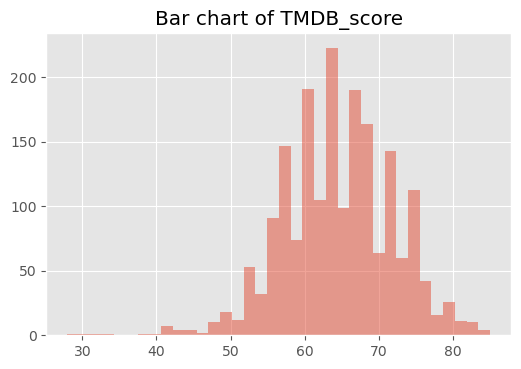

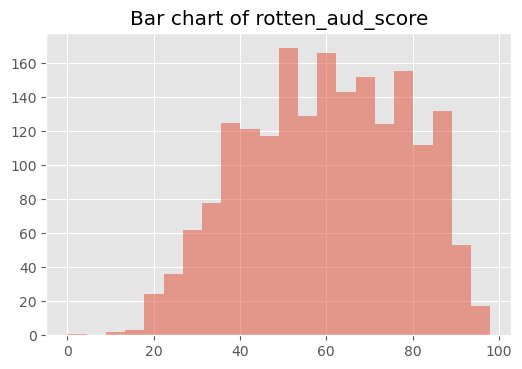

In [27]:
_ = plt.hist(df_compare_rating_2['TMDB_score'], bins = 'auto', alpha=0.5)
plt.title('Bar chart of TMDB_score')
plt.show()

_ = plt.hist(df_compare_rating_2['rotten_aud_score'], bins = 'auto', alpha=0.5)
plt.title('Bar chart of rotten_aud_score')
plt.show()

從長條圖我們認定兩組資料為常態分佈。

Let 'TMDB_score' be $\mu_1$, 'rotten_aud_score' be $\mu_2$, and $\mu_D = \mu_1 - \mu_2$.

+ $H_0$: $\mu_D = 0$
+ $H_1$: $\mu_D \ne 0$

In [28]:
alpha = 0.05
# use matched-pair experiment
# t-test & estimator of mu_D
rotten = df_compare_rating_2['TMDB_score'].values
aud = df_compare_rating_2['rotten_aud_score'].values

diff = rotten - aud
nobs = diff.shape[0]
df = nobs - 1
print("degree of freedom = ", df)

diff_desc = stats.describe(diff)
t_value = (diff_desc.mean - 0) / (diff_desc.variance ** 0.5) * (nobs ** 0.5)
print(f"t-value = {t_value:.4f}")

#p-values
ptmp = stats.t.cdf(t_value, df)
p_value = 2 * (1 - ptmp)
print(f"p_value (two tail) = {p_value:.4f}")

degree of freedom =  1920
t-value = 15.6619
p_value (two tail) = 0.0000


由檢定結果發現 p-value < 0.05，因此我們可以拒絕虛無假設，推論TMDB和Rotten Tomato兩者評分不盡相同。

#### 3. 觀眾評分與電影類別的關係

我們認為觀眾評分時，不只會考量電影作品本身的內容，也有可能因為電影類別而有所偏頗，導致特定類別的電影評分較高或較低。

In [29]:
movie_gen_dummy = pd.read_csv('../data/movie_gen_dummy.csv', index_col=0)
movie_gen_dummy.dropna(inplace=True)

movie_gen_df = movie_gen_dummy.copy()
movie_gen_df = movie_gen_df.loc[:, 'Action':]
movie_gen_df['rotten_aud_score'] = movie_gen_dummy['rotten_aud_score']
movie_gen_df['revenue'] = movie_gen_dummy['revenue']
movie_gen_df['release_date'] = movie_gen_dummy['release_date']
movie_gen_df['t'] = movie_gen_df.index
movie_gen_df.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,...,Romance,Science Fiction,TV Movie,Thriller,War,Western,rotten_aud_score,revenue,release_date,t
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,37.0,161834276,2000-02-03,0
1,0,1,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,57.0,144056873,2000-02-03,1
2,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,62.0,45554533,2000-02-11,2
3,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,78.0,28780255,2000-02-18,3
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,64.0,106371651,2000-02-18,4


In [30]:
x_names = list(movie_gen_df.columns[:-4])
y_name = 'rotten_aud_score'

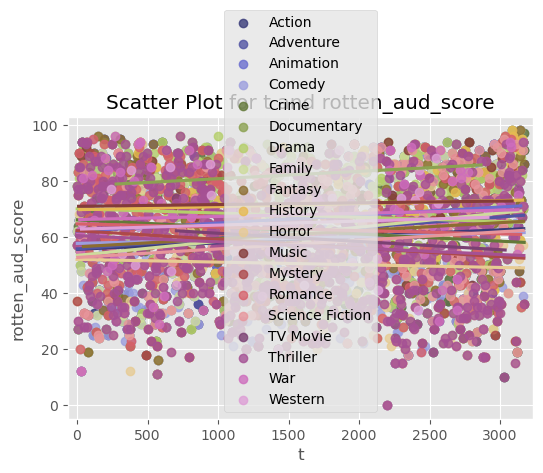

In [31]:
mgt2001.model.multi_variable_plot(x_name='t', y_name=y_name, df=movie_gen_df, x_names=x_names)

我們可以發現去掉 outlier 之後，TV Movie 變得都沒有值，於是我們先將 TV Movie 從我們的x variables 去除。

In [32]:
x_names.remove('TV Movie')

In [33]:
mgt2001.model.multicollinearity(movie_gen_df, x_names, y_name)

,rotten_aud_score,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
rotten_aud_score,1.000000,-0.072712,0.010480,0.081508,-0.076182,0.019604,0.068321,0.284582,-0.009891,-0.007933,0.118613,-0.215921,0.088270,-0.064819,0.039519,-0.074720,-0.151678,0.057351,0.019296
Action,-0.072712,1.000000,0.300667,-0.062349,-0.217245,0.163743,-0.020616,-0.262954,-0.128521,0.075313,-0.003512,-0.128270,-0.102012,-0.073727,-0.250449,0.282553,0.200750,0.068248,0.023995
Adventure,0.010480,0.300667,1.000000,0.279226,-0.022261,-0.170204,-0.035839,-0.261147,0.323533,0.299681,-0.035323,-0.163458,-0.062468,-0.085358,-0.146441,0.216497,-0.160520,-0.008652,0.057431
Animation,0.081508,-0.062349,0.279226,1.000000,0.190116,-0.123369,0.001513,-0.213262,0.617706,0.138758,-0.063693,-0.108290,0.007351,-0.072257,-0.105863,-0.013178,-0.180523,-0.032281,-0.003284
Comedy,-0.076182,-0.217245,-0.022261,0.190116,1.000000,-0.123181,-0.015364,-0.219136,0.282930,0.019863,-0.135051,-0.194495,0.044492,-0.179833,0.213231,-0.187121,-0.415738,-0.099170,-0.025846
Crime,0.019604,0.163743,-0.170204,-0.123369,-0.123181,1.000000,-0.014331,0.053004,-0.160053,-0.146036,-0.028657,-0.095999,-0.064056,0.080135,-0.162176,-0.145410,0.301992,-0.062450,0.012851
Documentary,0.068321,-0.020616,-0.035839,0.001513,-0.015364,-0.014331,1.000000,-0.024142,-0.009186,-0.025642,-0.014800,-0.025162,0.024996,-0.022263,-0.029879,-0.026803,-0.044778,0.022440,-0.007057
Drama,0.284582,-0.262954,-0.261147,-0.213262,-0.219136,0.053004,-0.024142,1.000000,-0.226440,-0.183543,0.225654,-0.182227,0.093785,0.009039,0.194919,-0.198718,-0.017663,0.128135,0.004394
Family,-0.009891,-0.128521,0.323533,0.617706,0.282930,-0.160053,-0.009186,-0.226440,1.000000,0.266882,-0.084720,-0.140628,0.045384,-0.108680,-0.074489,-0.059026,-0.251475,-0.058772,-0.018821
Fantasy,-0.007933,0.075313,0.299681,0.138758,0.019863,-0.146036,-0.025642,-0.183543,0.266882,1.000000,-0.083869,-0.046360,-0.003607,-0.058107,0.000915,-0.023976,-0.151065,-0.044426,-0.029122


In [34]:
# res_dict, assessment = mgt2001.model.MultipleRegression(x_names=x_names, y_name=y_name, df=movie_gen_df, assessment=False, t_test_c=0, t_test_option='two-tail')
# 我跑出來不知道為什麼會有error，就先跳過這一段了

### 五、票房與原始語言的關係

一部電影之原始語言通常會進而影響其風格以及目標客群，希望可以透過此分析探討若該電影之原始語言為世界上較多人口使用之語言，像是英文，會不會因為較多人聽得懂原版而廣泛流傳、進而提升票房。抑或是有特定語言之電影之票房特別突出。

In [35]:
language_df = u_movie_df[['original_language', 'revenue']].copy()
print("Head of data set:\n")
display(language_df.head())
print("Tail of data set:\n")
display(language_df.tail())

Head of data set:



,original_language,revenue
0,en,161834276
1,en,144056873
2,en,45554533
3,en,28780255
4,en,106371651


Tail of data set:



,original_language,revenue
2243,en,6416063
2244,en,47019435
2245,en,30763855
2246,en,76706000
2247,en,80648577


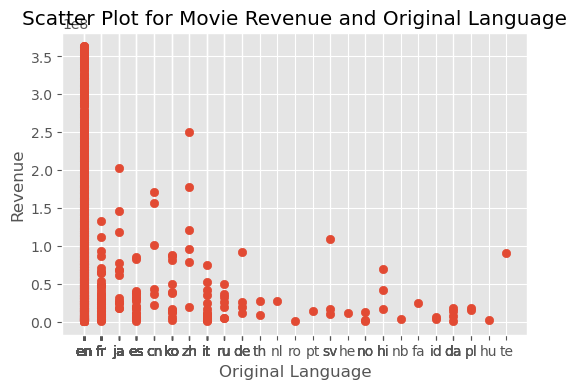

In [36]:
plt.scatter(language_df['original_language'], language_df['revenue'])
plt.title('Scatter Plot for Movie Revenue and Original Language')
plt.xlabel('Original Language')
plt.ylabel('Revenue')
plt.xticks(language_df['original_language'])
plt.show()

**檢查資料是否為常態分佈**

考量到部分語言電影之資料筆數 < 3 、無法進行 Shapiro Wilk's Test，且資料筆數少較難真實呈現該語言電影的真實票房，故先將其予以排除

In [37]:
three_bound_index = list(language_df.groupby('original_language').count()[language_df.groupby('original_language').count()['revenue'] >= 3].index)
proper_lang_df = language_df[language_df['original_language'].apply(lambda x: x in three_bound_index)]
proper_lang_df

,original_language,revenue
0,en,161834276
1,en,144056873
2,en,45554533
3,en,28780255
4,en,106371651
...,...,...
2243,en,6416063
2244,en,47019435
2245,en,30763855
2246,en,76706000


$H_0$: The population is normally distributed
$H_1$: The population is not normally distributed

In [38]:
treatment_name_list = proper_lang_df['original_language'].unique()
print(treatment_name_list)
anova.shapiro(proper_lang_df, treatment_name_list, 'original_language', 'revenue')
# anova.qq_plot(4, 4, proper_lang_df, treatment_name_list, 'original_language', 'revenue', figsize=(16, 16))

['en' 'fr' 'ja' 'es' 'cn' 'ko' 'zh' 'it' 'ru' 'de' 'sv' 'no' 'hi' 'da']
1: Statistics=0.8622, p=0.0000
2: Statistics=0.7991, p=0.0000
3: Statistics=0.8380, p=0.0200
4: Statistics=0.8156, p=0.0009
5: Statistics=0.8704, p=0.2276
6: Statistics=0.8520, p=0.0388
7: Statistics=0.9767, p=0.9340
8: Statistics=0.7753, p=0.0009
9: Statistics=0.9471, p=0.7028
10: Statistics=0.7685, p=0.0567
11: Statistics=0.7945, p=0.1014
12: Statistics=0.7951, p=0.1030
13: Statistics=0.9992, p=0.9467
14: Statistics=0.9850, p=0.9307


雖然沒有符合 Required Conditions，因為難以比較，所以仍透過 One Way ANOVA 來幫助我們釐清關係。

+ $H_0$: All population means are equal<br>
+ $H_1$: Not all population means are equal

In [39]:
results, aov_table, render_table, f_stat, p_value = anova.f_oneway(proper_lang_df, 'original_language', 'revenue')
display(aov_table)
print(f"p-value = {p_value:.4f}")

p-value: 1.5192931565984133e-11


,sum_sq,df,F,PR(>F)
C(original_language),4.882633e+17,13.0,6.191572,1.519293e-11
Residual,1.346675e+19,2220.0,NaN,NaN


p-value = 0.0000


In [40]:
mc = smm.MultiComparison(proper_lang_df['revenue'], proper_lang_df['original_language'])
print(mc.tukeyhsd().summary())

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
group1 group2    meandiff    p-adj       lower          upper      reject
-------------------------------------------------------------------------
    cn     da -78186062.3333    0.9 -246983944.8849  90611820.2183  False
    cn     de -51330565.0833    0.9 -220128447.6349 117467317.4683  False
    cn     en  -1745540.8449    0.9 -108657304.0201 105166222.3302  False
    cn     es -63415783.1515 0.8866 -183854096.6198  57022530.3168  False
    cn     fr -60845438.3177 0.8471 -172494743.0842  50803866.4488  False
    cn     hi -45222149.8333    0.9 -230130965.6986 139686666.0319  False
    cn     it -70414459.0686 0.7998  -194590110.612  53761192.4748  False
    cn     ja -20253176.9872    0.9 -149316283.5459 108809929.5716  False
    cn     ko -50784554.4167    0.9 -181534832.0162  79965723.1828  False
    cn     no    -82879404.5    0.9 -267788220.3652 102029411.3652  False
    cn     ru -63582420.4048    0.9  -

/Users/pochenyeh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



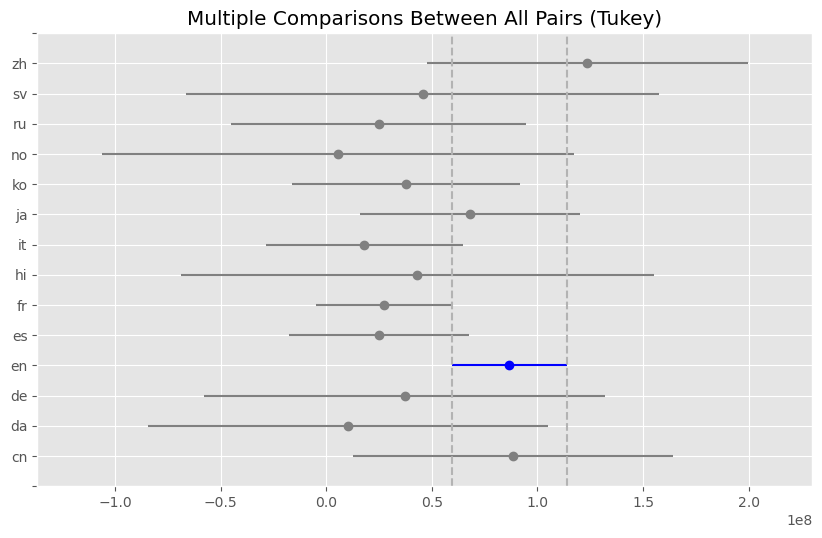

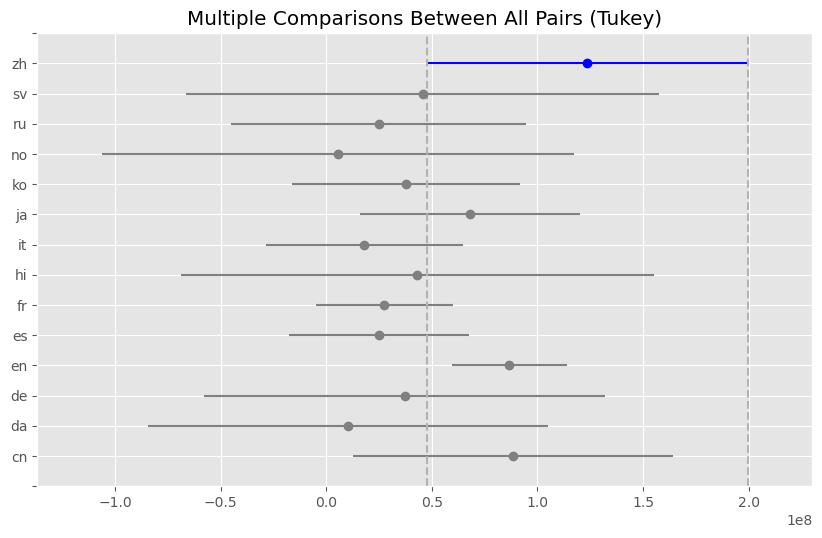

In [41]:
_ = mc.tukeyhsd().plot_simultaneous(comparison_name = "en")
_ = mc.tukeyhsd().plot_simultaneous(comparison_name = "zh")

Pairs `en` and `es`, `en` and `fr`, `en` and `it` can reject the null hypothesis under 5% confidence level. Moreover, by observing the graph above, we can know that the mean of `en` is larger than the mean of `es`, `fr`, `it`.

結果顯示原始語言為英文的電影票房較西班牙語、法語、義大利語電影好的狀況，不過因為整體資料筆數太懸殊、幾乎都是英文片所以意義不大。

為更了解各原始語言電影之票房分佈，繪製以下 Box Plot。

In [42]:
lan_list = proper_lang_df['original_language'].unique()

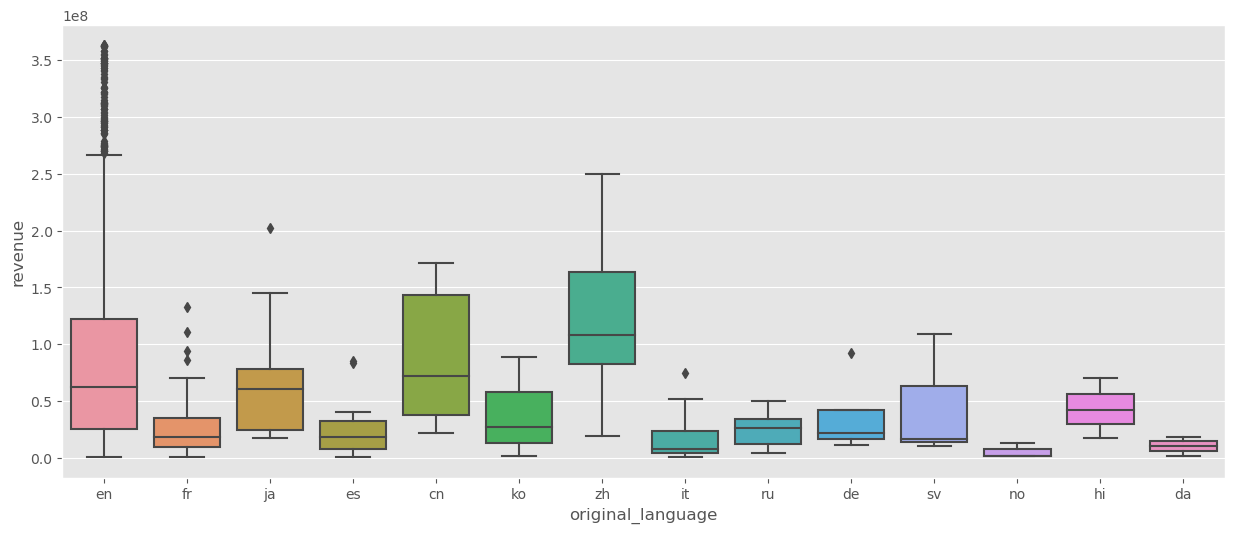

In [43]:
fig = plt.figure(figsize=(15, 6))
ax = sns.boxplot(x='original_language', y="revenue", data=proper_lang_df)
plt.show()

在這裏我們也可以看到，中文電影的平均票房表現其實也不差。甚至高於英文電影的平均票房。